#### Modelos de clasificación con selección de características y ajuste de hiperparámetros
 Tipo de Selección utilizada de base para Clasificación : SFS-BSC
 
 Autores:
     - Galván, Hugo César
     - Boveda, Agustina
     - Koss, Pablo
     - Galván, Sebastián
     


In [1]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline

In [2]:
# Estandarizador (transforma las variables en z-scores)
import scipy.stats as st
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score # Accuracy metrics 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scikitplot.metrics import plot_roc


In [3]:
import utils as ut
import pickle
# Indicamos que los tipos de datos float se muestren con 2 decimales
pd.options.display.float_format = '{:.2f}'.format

In [4]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

In [5]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [6]:
df = load_data_prep()

In [7]:
df1 = df[[ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length',
 'sl2l_volume', 'tral_volume','label']]
df1.shape

(96, 7)

In [8]:
# Partición en train y test
y = df1.loc[:, df1.columns == 'label']
X = df1.loc[:, df1.columns != 'label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [9]:
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

In [10]:
# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

### Modelo de Clasificación: Regresión Logística

In [11]:
logreg = LogisticRegression()
logreg.fit(X_scaled, y_train)

LogisticRegression()

In [12]:
y_train_pred = logreg.predict(X_scaled)
y_pred = logreg.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(logreg.score(X_test_scaled, y_test)))

Accuracy: 0.90


In [13]:
import sklearn.metrics as metrics

In [14]:
y_train_pred.argmax()

2

In [15]:
train_accuracy =  metrics.accuracy_score(y_train_pred,y_train) 
test_accuracy =  metrics.accuracy_score(y_pred, y_test)
print(f'Accuracy en el train set: {train_accuracy:.2f}')
print(f'Accuracy en el test set: {test_accuracy:.2f}')


Accuracy en el train set: 0.74
Accuracy en el test set: 0.90


In [16]:
print(classification_report(y_true=y_test,y_pred=logreg.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.92      0.92      0.92        12

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



In [17]:
y_test_=y_test.values

In [18]:
valor2 = logreg.predict(X_test_scaled.tolist()).tolist()
valor1 = y_test.label.values.tolist()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valor1, valor2) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[ 7  1]
 [ 1 11]]
Sensibilidad del modelo es de: 0.9167
Especificidad del modelo es de: 0.875
BA del modelo es de: 0.8958


In [20]:
#!pip install -U --upgrade scikit-learn

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 7  1]
 [ 1 11]]


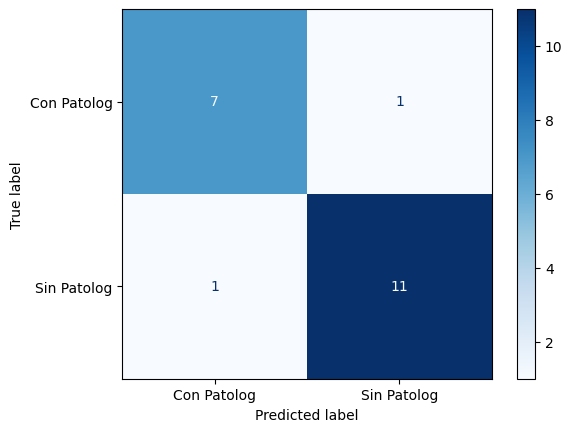

In [22]:
class_names = ['Con Patolog', 'Sin Patolog']
ConfusionMatrixDisplay.from_estimator(logreg, X_test_scaled, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()


In [23]:
# MODEL_PATH = '../data/union/End/model_logreg.pkl'
# with open(MODEL_PATH, 'wb') as f:
#    pickle.dump(logreg, f) 

In [24]:
# !pip install -q -U lightgbm
# !pip install -q -U catboost
# !pip install scikit-plot

### Modelos de Clasificación: 
* XGBClassifier
* LGBMClassifier
* CatBoostClassifier
* Ajustes de hipérparámetros con GridSearchCV
* Transformación de datos numéricos con PolynomialFeatures
* Canalización de datos con Pipeline

In [25]:
num_columns = [ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length', 'sl2l_volume', 'tral_volume']

In [26]:
# vamos a usar polynomial features sobre las variables numéricas
poly = PolynomialFeatures()
# Las categorías "nue
# vas" que aparezcan se imputan con el valor de unknown_value
# o_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=99999999)

In [27]:
pipeline = Pipeline([
    ("selector_num", ColumnTransformer(
        [
            ("poly", poly, num_columns)
        ], remainder="passthrough")
    ),
    ("classifier", CatBoostClassifier())
    ]
)

In [28]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

In [29]:
# este diccionario de parámetros lo vamos a usar tanto para XGBoost como para LightGBM
params = {  
    "classifier__n_estimators": st.randint(20,150), # n. de árboles.
    "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
    "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
    "classifier__colsample_bytree": one_to_left, # ratio de la muestra de las columnas a la hora de construir el árbol
    "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
    'classifier__reg_alpha': st.uniform(0.05,10),   # término de regularización L1
    "classifier__min_child_weight": st.uniform(1,20), # Suma mínima del peso de la instancia (hessiano) requerida en los hijos
}

In [30]:
other_params = {"selector_num__poly__degree": [1, 2, 3]}

In [31]:
search_space = [{"classifier": [XGBClassifier(n_jobs=3, eval_metric="logloss", use_label_encoder=False)], 
                 **params,
                 **other_params,
                "classifier__gamma": st.uniform(0, 10), # reducción mínima de la pérdida requerida para hacer un split
                },
                {"classifier": [LGBMClassifier(n_jobs=3, verbose=-1)],
                 **params,
                **other_params},
                {"classifier": [CatBoostClassifier(thread_count=3, verbose=False)],
                 **other_params,
                "classifier__n_estimators": st.randint(20,150), # n. de árboles.
                "classifier__max_depth": st.randint(3, 12),     # máxima profundiad del árbol
                "classifier__learning_rate": st.uniform(0.05, 0.4), # learning rate (xgb’s “eta”)
                "classifier__subsample": one_to_left,     # ratio de la muestra de las observaciones
                },
               {
                   "classifier": [LogisticRegression(max_iter=1000)],
                   "classifier__C": [10**x for x in range(-5, 3)],
               }]

In [32]:
model = RandomizedSearchCV(pipeline, search_space, n_iter=100, verbose=1, cv=3)
model.fit(X_train, y_train)

results = pd.DataFrame(model.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [33]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier', 'param_classifier__C',
       'param_classifier__colsample_bytree', 'param_classifier__learning_rate',
       'param_classifier__max_depth', 'param_classifier__min_child_weight',
       'param_classifier__n_estimators', 'param_classifier__reg_alpha',
       'param_classifier__subsample', 'param_selector_num__poly__degree',
       'param_classifier__gamma', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [34]:
model.best_score_

0.7235897435897436

In [35]:
model.best_params_

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7158880266624659, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=4.900422253852641, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.20829489044588684,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=2.8720523828089997, missing=nan,
               monotone_constraints=None, n_estimators=146, n_jobs=3,
               num_parallel_tree=None, predictor=None, random_state=None, ...),
 'classifier__colsample_bytree': 0.7158880266624659,
 'classifier__gamma': 4.900422253852641,
 'classifier__learning_rate': 0.20829489044588684,
 'class

In [36]:
model.best_estimator_

Pipeline(steps=[('selector_num',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['ccbd_diameter',
                                                   'sl2l_mean_length',
                                                   'sl2l_diameter',
                                                   'ccbd_mean_length',
                                                   'sl2l_volume',
                                                   'tral_volume'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               cols...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.20829489044588684, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None,
                               min_child_weight=2.8720523828089997, missing=nan,
                               monotone_constraints=None, n_estimators=146,
                               n_jobs=3, num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [37]:
X_test_ = pd.DataFrame(X_test, columns=[ 'ccbd_diameter', 'sl2l_mean_length',
 'sl2l_diameter', 'ccbd_mean_length','sl2l_volume', 'tral_volume','label'])

In [38]:
y_predicted = model.predict_proba(X_test_)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

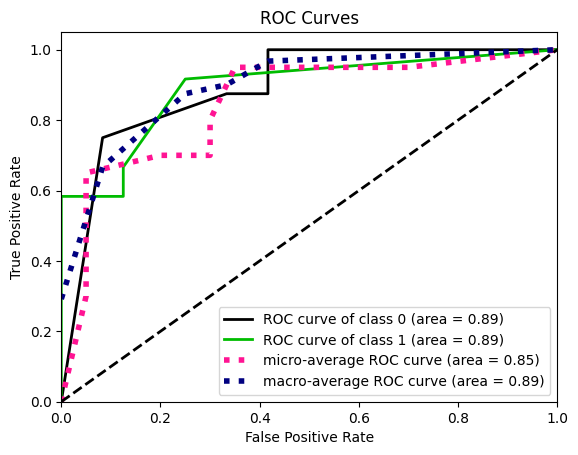

In [39]:
plot_roc(y_test, y_predicted)

In [40]:
roc_auc_score(y_test, y_predicted[:,1])

0.890625

In [41]:
print(classification_report(y_true=y_test,y_pred=model.predict(X_test_)))

              precision    recall  f1-score   support

           0       0.58      0.88      0.70         8
           1       0.88      0.58      0.70        12

    accuracy                           0.70        20
   macro avg       0.73      0.73      0.70        20
weighted avg       0.76      0.70      0.70        20



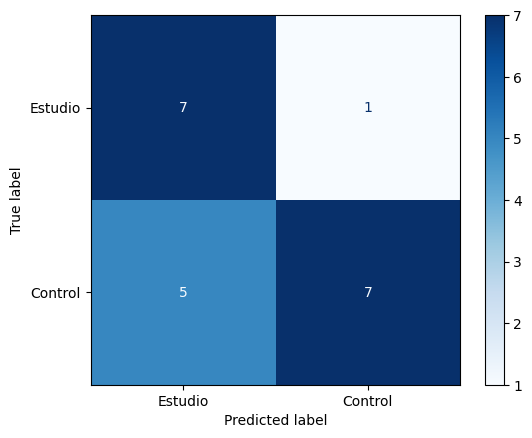

In [42]:
class_names = ['Estudio', 'Control']
ConfusionMatrixDisplay.from_estimator(model, X_test_, y_test, display_labels=class_names, cmap=plt.cm.Blues)
plt.show()

In [43]:
valor4 = model.predict(X_test).tolist()
valor3 = y_test.label.values.tolist()

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valor3, valor4) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[7 1]
 [5 7]]
Sensibilidad del modelo es de: 0.875
Especificidad del modelo es de: 0.5833
BA del modelo es de: 0.7292


In [45]:
# MODEL_PATH = '../data/union/End/model_LGBMClassifier.pkl'
# with open(MODEL_PATH, 'wb') as f:
#     pickle.dump(model.best_estimator_, f) 

In [46]:
model.best_estimator_

Pipeline(steps=[('selector_num',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['ccbd_diameter',
                                                   'sl2l_mean_length',
                                                   'sl2l_diameter',
                                                   'ccbd_mean_length',
                                                   'sl2l_volume',
                                                   'tral_volume'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               cols...
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.20829489044588684, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None,
                               min_child_weight=2.8720523828089997, missing=nan,
                               monotone_constraints=None, n_estimators=146,
                               n_jobs=3, num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [47]:
model.predict_proba

<bound method BaseSearchCV.predict_proba of RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('selector_num',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('poly',
                                                                               PolynomialFeatures(),
                                                                               ['ccbd_diameter',
                                                                                'sl2l_mean_length',
                                                                                'sl2l_diameter',
                                                                                'ccbd_mean_length',
                                                                                'sl2l_volume',
                                                                                'tral_volume'])])),
   

In [48]:
# !pip install -q -U ngboost

In [49]:
from ngboost import NGBRegressor
from sklearn.metrics import mean_squared_error

In [50]:
X_train

,ccbd_diameter,sl2l_mean_length,sl2l_diameter,ccbd_mean_length,sl2l_volume,tral_volume
83,29.94,86.39,23.42,137.00,37227.10,14393.77
4,24.65,76.13,25.37,131.73,38485.50,22291.20
42,29.25,72.08,22.21,108.75,27935.80,11856.10
75,29.57,70.99,25.00,124.56,34850.40,14943.70
25,30.00,75.49,23.56,119.14,32924.20,14664.60
...,...,...,...,...,...,...
73,15.76,95.79,20.16,132.43,30585.70,4747.53
40,26.73,85.09,23.02,120.77,35408.60,25257.50
57,27.56,76.86,22.55,125.91,30702.20,10761.30
35,21.73,85.55,15.39,99.87,15909.30,8259.21


In [51]:
ngb = NGBRegressor().fit(X_train, y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

# test Mean Squared Error
test_MSE = mean_squared_error(Y_preds, y_test)
print('Test MSE', test_MSE)

# test Negative Log Likelihood
test_NLL = -Y_dists.logpdf(y_test).mean()
print('Test NLL', test_NLL)

[iter 0] loss=0.7258 val_loss=0.0000 scale=2.0000 norm=1.0000
[iter 100] loss=0.0360 val_loss=0.0000 scale=2.0000 norm=0.8242
[iter 200] loss=-0.4192 val_loss=0.0000 scale=2.0000 norm=0.7775
[iter 300] loss=-0.7469 val_loss=0.0000 scale=1.0000 norm=0.3579
[iter 400] loss=-1.0396 val_loss=0.0000 scale=1.0000 norm=0.3307
Test MSE 0.10372984891218935
Test NLL 50.43224321346594
